In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import numpy as np
import surgeon

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'

# Loading four Toy datasets and data preparation

In [5]:
adata = sc.read("./data/panorama/panorama_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 24552 × 2000 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [6]:
adata.obs[cell_type_key].value_counts()

Macrophage                  6596
PBMC T cells                3576
PBMC CD4 T cells            2140
Jurkat                      1846
Neuron                      1806
PBMC CD56+ NK               1390
PBMC CD14+ monocyte          999
Pancreas Alpha               971
Pancreas Beta                936
293t                         896
PBMC CD8 T cells             798
PBMC CD19+ B cells           690
Pancreas Ductal              389
Hsc MEP                      260
Hsc GMP                      237
Pancreas Delta               233
Pancreas Endothelial         161
Pancreas Acinar              136
Hsc CMP                      135
Pancreas Gamma               120
Pancreas Stellate            114
Pancreas Unkonwn              61
Pancreas Beta(ER stress)      60
Hsc Unknown                    2
Name: cell_type, dtype: int64

In [7]:
adata.obs[condition_key].value_counts()

Macrophage Uninfected     3626
PBMC 68K                  3601
Macrophage Infected       2397
Neuron9K                  1806
Pancreas inDrop           1713
CD56 NK                   1331
Jurkat 293t 99:1           837
Cytotoxic T Cells          798
PBMC Kang                  754
CD4 T Helper               742
Memory T Cells             725
Jurkat 293t 50:50          677
Regulatory T Cells         673
Jurkat                     651
Pancreas SS2               597
293t                       577
Pancreas CelSeq2           489
HSC Mars                   480
PBMC 10X                   458
B Cells                    452
Macrophage Mixed           434
Pancreas Celseq            255
HSC SS2                    154
Macrophage Uninfected2     139
Pancreas Fluidigm C1       127
CD14 Monocytes              59
Name: study, dtype: int64

In [8]:
celltypes_to_remove = ['Hsc Unknown', 'Pancreas Beta(ER stress)', 'Pancreas Unkonwn']

In [9]:
adata = adata[~adata.obs[cell_type_key].isin(celltypes_to_remove)]
adata

View of AnnData object with n_obs × n_vars = 24429 × 2000 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((20764, 2000), (3665, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_labels = len(train_adata.obs[cell_type_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.NNClassifier(x_dimension=train_adata.shape[1], 
                                     z_dimension=10,
                                     cvae_network=None,
                                     n_labels=n_labels,
                                     lr=0.001,
                                     alpha=0.001,
                                     eta=1.0,
                                     clip_value=1000.0,
                                     model_path="./models/NNClassifier/scratch/",
                                     dropout_rate=0.5,
                                     )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          256000      data[0][0]                       
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)  

## Training the network

In [14]:
network.train(train_adata,
              valid_adata, 
              cell_type_key=cell_type_key,
              n_epochs=10000,
              batch_size=128, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 20764 samples, validate on 3665 samples
Epoch 1/10000
 - 1s - loss: 2.4348 - acc: 0.5514 - val_loss: 0.5371 - val_acc: 0.8232
Epoch 2/10000
 - 0s - loss: 0.7790 - acc: 0.7902 - val_loss: 0.4222 - val_acc: 0.8505
Epoch 3/10000
 - 0s - loss: 0.5237 - acc: 0.8346 - val_loss: 0.4350 - val_acc: 0.8529
Epoch 4/10000
 - 0s - loss: 0.4793 - acc: 0.8481 - val_loss: 0.3834 - val_acc: 0.8671
Epoch 5/10000
 - 0s - loss: 0.3997 - acc: 0.8707 - val_loss: 0.3497 - val_acc: 0.8731
Epoch 6/10000
 - 0s - loss: 0.3014 - acc: 0.8967 - val_loss: 0.3311 - val_acc: 0.8799
Epoch 7/10000
 - 0s - loss: 0.2885 - acc: 0.9021 - val_loss: 0.3253 - val_acc: 0.8857
Epoch 8/10000
 - 0s - loss: 0.2421 - acc: 0.9163 - val_loss: 0.3290 - val_acc: 0.8846
Epoch 9/10000
 - 0s - loss: 0.2423 - acc: 0.9127 - val_loss: 0.3349 - val_acc: 0.8857
Epoch 10/10000
 - 0s - loss: 0.2163 - acc: 0.9236 - val_loss: 0.3410 - val_acc: 0.8843
Epoch 11/10000
 - 1s - loss: 0.1913 - acc:

In [15]:
latent_adata = network.to_latent(adata)
latent_adata

AnnData object with n_obs × n_vars = 24429 × 10 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'

In [16]:
latent_adata.X

array([[ 3.44924426e+00, -3.78165054e+01,  4.10876541e+01, ...,
         1.98557301e+01, -8.24789619e+00,  1.93305569e+01],
       [ 1.96040859e+01, -3.86362991e+01,  4.94759254e+01, ...,
         2.71118584e+01, -1.82628746e+01,  4.69557531e-02],
       [ 4.87547064e+00, -3.30613022e+01,  5.60840034e+01, ...,
         1.30119371e+01,  4.75746965e+00,  7.42712975e+00],
       ...,
       [-1.19107640e+00,  4.43862228e+01,  5.02062464e+00, ...,
        -2.20365219e+01,  1.30315590e+01,  3.02764378e+01],
       [-1.17250805e+01,  3.25950737e+01,  9.30498028e+00, ...,
        -7.24752331e+00,  2.08424416e+01,  2.78706989e+01],
       [ 8.09637451e+00,  3.63435898e+01,  1.04779291e+01, ...,
        -2.98544178e+01,  1.96493015e+01,  4.56394911e+00]], dtype=float32)

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


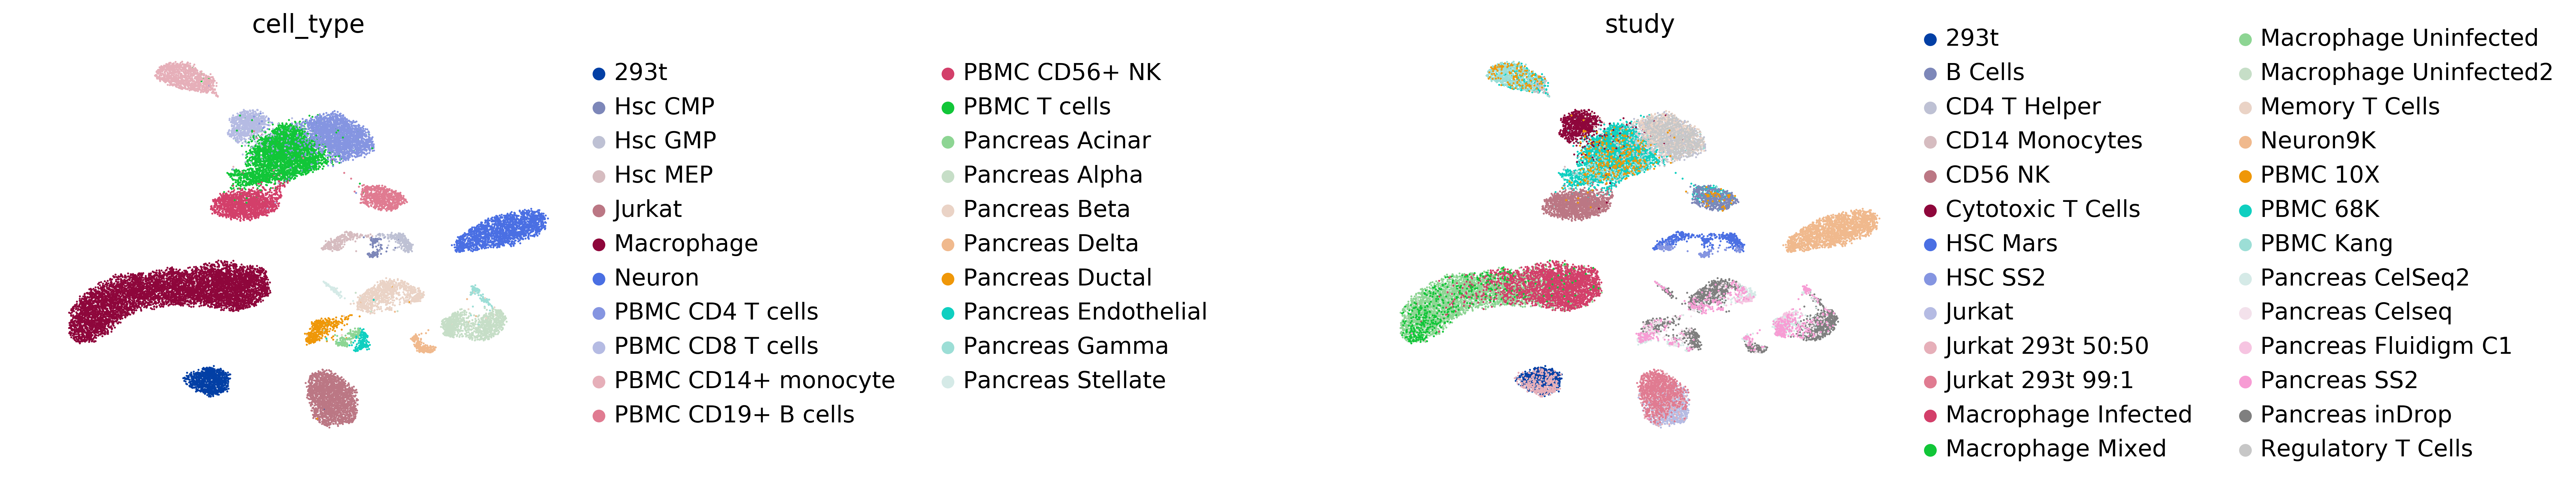

In [18]:
sc.pl.umap(latent_adata, color=[cell_type_key, condition_key], wspace=1.3, frameon=False,
           save="_latent_MLP.pdf")

In [28]:
adata.obs[condition_key].value_counts()

Macrophage Uninfected     18130
PBMC 68K                  18006
Macrophage Infected       11989
Neuron9K                   9032
Pancreas inDrop            8569
CD56 NK                    6657
Jurkat 293t 99:1           4185
Cytotoxic T Cells          3990
PBMC Kang                  3774
CD4 T Helper               3713
Memory T Cells             3628
Jurkat 293t 50:50          3388
Regulatory T Cells         3365
Jurkat                     3257
Pancreas SS2               2989
293t                       2885
Pancreas CelSeq2           2449
HSC Mars                   2401
PBMC 10X                   2293
B Cells                    2261
Macrophage Mixed           2174
Pancreas Celseq            1276
HSC SS2                     774
Macrophage Uninfected2      698
Pancreas Fluidigm C1        638
CD14 Monocytes              295
Name: study, dtype: int64

In [30]:
pbmc_conds = ['PBMC Kang', 'PBMC 68K', 'CD56 NK', 'Cytotoxic T Cells', 'CD4 T Helper', 'Memory T Cells', 'Regulatory T Cells', 'PBMC 10X', 'B Cells', 'CD14 Monocytes']
pbmc_adata = adata[adata.obs[condition_key].isin(pbmc_conds)]
pbmc_adata

In [31]:
sc.pp.neighbors(pbmc_adata)
sc.tl.umap(pbmc_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


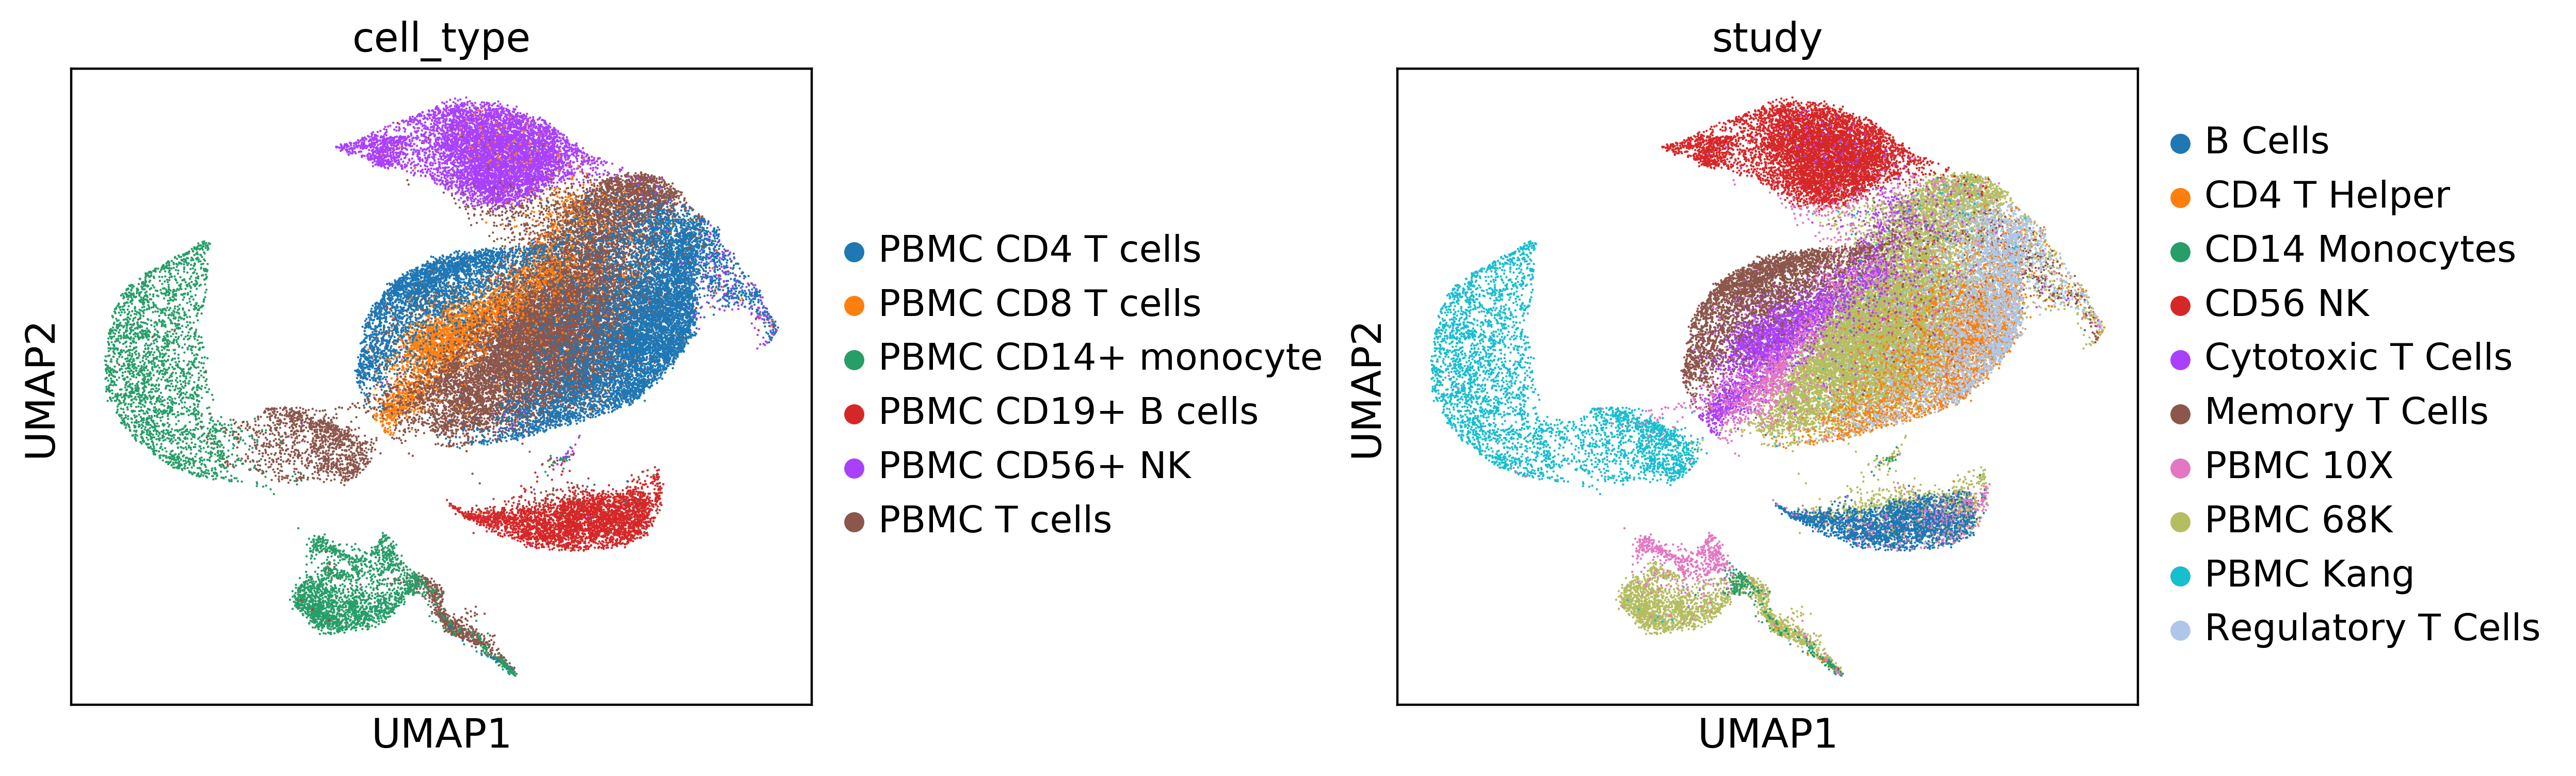

In [32]:
sc.pl.umap(pbmc_adata, color=[cell_type_key, condition_key], wspace=0.63)

In [27]:
adata = sc.read("./data/panorama/panorama.h5ad")
adata

AnnData object with n_obs × n_vars = 122816 × 5216 
    obs: 'batch', 'cell_type', 'study'

In [36]:
pbmc_adata.write_h5ad("./data/pbmc_panorama/pbmc_panorama.h5ad")

In [38]:
sc.pp.normalize_total(pbmc_adata, key_added='size_factors')
sc.pp.log1p(pbmc_adata)

In [43]:
sc.pp.highly_variable_genes(pbmc_adata, n_top_genes=2000)

Trying to set attribute `.var` of view, making a copy.


In [44]:
pbmc_adata = pbmc_adata[:, pbmc_adata.var['highly_variable']]
pbmc_adata

View of AnnData object with n_obs × n_vars = 47982 × 2002 
    obs: 'batch', 'cell_type', 'study', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'cell_type_colors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [45]:
pbmc_adata.write_h5ad("./data/pbmc_panorama/pbmc_panorama_normalized.h5ad")